## Workflow lessons

In [1]:
# Import libraries
import warnings
from glob import glob
import os

import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import re  # regular expressions

import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em

# Get Landsat data
et.data.get_data(url="https://ndownloader.figshare.com/files/21941085")

os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))
warnings.simplefilter('ignore')

In [2]:
def crop_stack_data(files_to_crop, crop_path, crop_bound):
    """Crops a set of tif files and saves them in a crop directory.
    Returns a stacked numpy array of bands"""
    if not os.path.exists(crop_path):
        os.mkdir(crop_path)

    with rio.open(all_files[0]) as src:
        fire_bound_reproject = fire_boundary.to_crs(src.crs)

    es.crop_all(raster_paths=all_files,
                output_dir=crop_path,
                geoms=fire_bound_reproject,
                overwrite=True)
    # Get a list of bands to stack
    all_bands = sorted(glob(os.path.join(crop_path, "*band*.tif")))

    # Stack the bands for NDVI and NBR calculation
    return es.stack(all_bands)


def mask_data(arr, path_to_qa):
    """Function that masks a numpy array using a cloud qa layer"""

    # 1. open the qa layer
    with rio.open(pixel_qa_path[0]) as src:
        mask_arr = src.read(1)

    # Cloud mask values
    high_cloud_confidence = em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"]
    cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
    cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

    all_masked_values = cloud_shadow + cloud + high_cloud_confidence
    # 2. mask the numpy array
    # Create test to ensure the values are in the mask qa layer
    if any(i in np.unique(mask_arr) for i in all_masked_values):
        landsat_masked_bands = em.mask_pixels(landsat_bands,
                                              mask_arr,
                                              vals=all_masked_values)
        return landsat_masked_bands
    else:
        print("There are no pixels to mask")
        return arr

After creating the functions notice how much easier the code is to read!
At this point you have a working loop and you can continue to add pieces of 
your workflow.

Functions are a nice way to organize your work because they allow you to 
modularize your workflow, extracting steps into individual components that you 
can test. 

In [3]:
# Open fire boundary 
fire_boundary_path = os.path.join("cold-springs-fire",
                                  "vector_layers",
                                  "fire-boundary-geomac",
                                  "co_cold_springs_20160711_2200_dd83.shp")
fire_boundary = gpd.read_file(fire_boundary_path)


In [4]:
data_path = os.path.join("earthpy-downloads", "landsat-coldsprings-hw")
# view subdirectories of data
all_dirs = glob(os.path.join(data_path, "*"))

#####
# High level

# First create the high level loop to loop through 1) each landsat directory and then 2) the files
for landsat_dir in all_dirs:
    all_files = []
    # print(landsat_dir)
    # Get all tif files in the directory
    all_files = sorted(glob(os.path.join(landsat_dir, "*.tif")))
    crop_path = os.path.join(landsat_dir, "cropped")

    # crop & stack data - note that the no data values have NOT been accounted for yet
    landsat_arr, landsat_meta = crop_stack_data(files_to_crop=all_files,
                                                crop_path=crop_path,
                                                crop_bound=fire_boundary)

    # Mask data
    pixel_qa_path = glob(os.path.join(crop_path, "*pixel_qa*.tif"))
    landsat_mask = mask_data(landsat_arr, pixel_qa_path)


# Calculate nbr

# Calculate dNBR from pre-post fire nbr

# Reclassify dnbr to create final plot

# Plot data



There are no pixels to mask
There are no pixels to mask


Now the code is simpler however there is a remaining issue. the loop processes 
the data for each site but it overwrites the resulting data each time which 
means that you will not be able to calculate NDVI difference. 

Here you have a few options.

1. Create a list of masked arrays and use this list: This could work well and it will scale. It will however require you to keep track of the array index in the list so keep that in mind.  
2. If your loop is small you could create custom variable names for each returned array.
3. You could write out intermediate stacked tif files if you want. Sometimes this option is nice when you have a big workflow that may need to be "Started" somewhere in the middle at some point rather than from the beginning.
4. Create a dictionary with a custom key name (this is an ideal option).

In [5]:
# First create the high level loop to loop through 1) each landsat directory and then 2) the files
landsat_data = {}

for landsat_dir in all_dirs:
    all_files = []
    # print(landsat_dir)
    # Get all tif files in the directory
    all_files = sorted(glob(os.path.join(landsat_dir, "*.tif")))
    crop_path = os.path.join(landsat_dir, "cropped")

    # crop & stack data
    landsat_arr, landsat_meta = crop_stack_data(files_to_crop=all_files,
                                                crop_path=crop_path,
                                                crop_bound=fire_boundary)

    # Mask data
    pixel_qa_path = glob(os.path.join(crop_path, "*pixel_qa*.tif"))

    # Get dir name - you could also chose to just use the date as the scene dictionary key
    
    landsat_scene = os.path.basename(os.path.normpath(landsat_dir))
    scene_date = landsat_scene[10:18]

    landsat_data[scene_date] = mask_data(landsat_arr, pixel_qa_path)


landsat_data

There are no pixels to mask
There are no pixels to mask


{'20160621': array([[[ 266,  325,  367, ...,  179,  194,  207],
         [ 209,  276,  411, ...,  236,  243,  261],
         [ 218,  259,  387, ...,  251,  236,  245],
         ...,
         [ 295,  312,  272, ...,  154,  161,  188],
         [ 292,  291,  271, ...,  164,  174,  199],
         [ 294,  278,  260, ...,  177,  188,  229]],
 
        [[ 372,  411,  456, ...,  270,  290,  307],
         [ 300,  370,  540, ...,  337,  348,  371],
         [ 323,  384,  516, ...,  370,  336,  347],
         ...,
         [ 400,  426,  380, ...,  251,  259,  297],
         [ 396,  398,  372, ...,  268,  289,  318],
         [ 396,  391,  366, ...,  283,  317,  332]],
 
        [[ 605,  603,  671, ...,  522,  535,  570],
         [ 518,  598,  767, ...,  599,  611,  639],
         [ 590,  663,  785, ...,  685,  583,  596],
         ...,
         [ 614,  679,  587, ...,  483,  484,  534],
         [ 615,  612,  609, ...,  500,  527,  584],
         [ 607,  607,  599, ...,  523,  571,  580]],
 
 

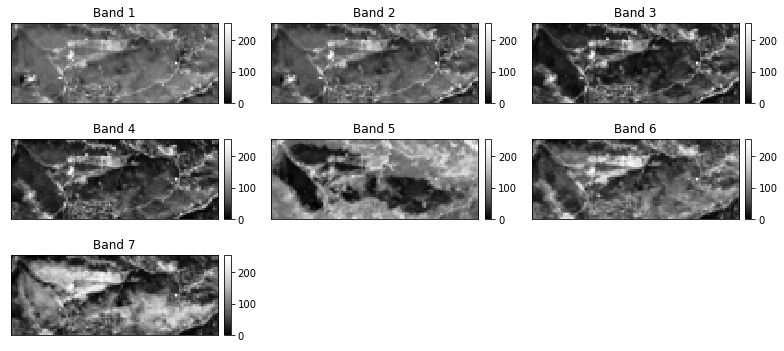

In [6]:
# Plot the data as a visual check
ep.plot_bands(landsat_data["20160723"],
             figsize=(11,5))
plt.show()

At this point you have a working loop that processes, crops, and stacks your 
data. You can at any time add additional cleaning steps to existing functions 
or you could create new functions and add those to the workflow. 

Next, you may want to calculate your vegetation indices using functions or steps.
Below two additional objects are created for ndvi and nbr respectively. Note that 
you could combine these into one dict or keep them separate depending upon 
your workflow! Or maybe you decided that you do'nt need the dict of cleaned 
data. you ONLY want the dict for NDVI and NBR

In [7]:
# Nested dictionary can be used to store information hierarchically as an option

veg_indices = {}

veg_indices["date"] = {"ndvi": .8, "nbr": .8}
                       
veg_indices["date"]["ndvi"] 

0.8

Below you create a nested dictionary to store information. You can then use this to calculate
your difference raster which you need for the final plots in this assignment.

In [8]:
# First create the high level loop to loop through 1) each landsat directory and then 2) the files
landsat_data = {}
veg_index = {}

for landsat_dir in all_dirs:
    all_files = []
    # print(landsat_dir)
    # Get all tif files in the directory
    all_files = sorted(glob(os.path.join(landsat_dir, "*.tif")))
    crop_path = os.path.join(landsat_dir, "cropped")

    # crop & stack data
    landsat_arr, landsat_meta = crop_stack_data(files_to_crop=all_files,
                                                crop_path=crop_path,
                                                crop_bound=fire_boundary)

    # Mask data
    pixel_qa_path = glob(os.path.join(crop_path, "*pixel_qa*.tif"))

    # Get dir name - you could also chose to just use the date as the scene dictionary key
    
    landsat_scene = os.path.basename(os.path.normpath(landsat_dir))
    scene_date = landsat_scene[10:18]

    cleaned_landsat = mask_data(landsat_arr, pixel_qa_path)
    
    # Calculate NDVI - note that the way this is written, it will only work for 
    # landsat / ndvi as the band numbers are hard coded.
    # Also note that the bands below are **NOT** correct below for NBR.
    veg_index[scene_date] = {"ndvi": es.normalized_diff(cleaned_landsat[4], cleaned_landsat[3]),
                       "nbr": "Add calculation for nbr here"} 
    
# Calculate difference -- this only happens once in this homework so it 
# belongs OUTSIDE of the loop

veg_index

There are no pixels to mask
There are no pixels to mask


{'20160621': {'ndvi': array([[0.5682955 , 0.53015605, 0.54238506, ..., 0.72693224, 0.65199839,
          0.55299539],
         [0.6602831 , 0.54867257, 0.38438438, ..., 0.63972736, 0.61467236,
          0.57752341],
         [0.63986014, 0.53495217, 0.35419735, ..., 0.56337136, 0.62398013,
          0.62295652],
         ...,
         [0.49162479, 0.46567281, 0.55887097, ..., 0.57371795, 0.58142018,
          0.52371027],
         [0.47592671, 0.50224398, 0.57437071, ..., 0.5620438 , 0.52084433,
          0.48544153],
         [0.49414317, 0.49425287, 0.54862237, ..., 0.53507424, 0.49279539,
          0.48444032]]), 'nbr': 'Add calculation for nbr here'},
 '20160723': {'ndvi': array([[0.56237219, 0.59093056, 0.57501848, ..., 0.75855856, 0.6795082 ,
          0.58659218],
         [0.76729272, 0.61756633, 0.35704514, ..., 0.63832335, 0.58804696,
          0.51624791],
         [0.66979656, 0.55391433, 0.3752495 , ..., 0.566341  , 0.66268657,
          0.6549127 ],
         ...,
        

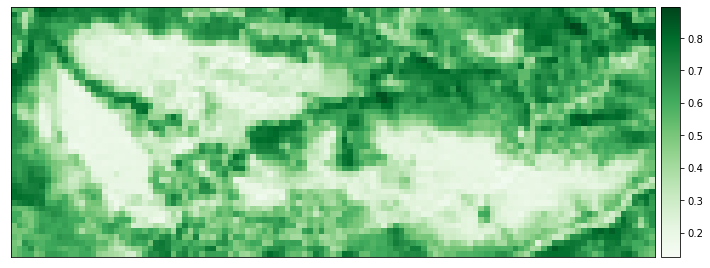

In [9]:
ep.plot_bands(veg_index["20160723"]["ndvi"],
             scale=False, cmap = "Greens")
plt.show()